In [3]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

# Set the paths to the datasets
image_dir = '/kaggle/input/fashion-mnist-images-new'
csv_file = '/kaggle/input/fashion-mnist-captions-new/Fashion_mnist_captions_new.csv'

2024-04-23 13:14:24.508019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 13:14:24.508147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 13:14:24.640430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Load the image and text data
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
data = pd.read_csv(csv_file)

In [5]:
data

,caption,class,filename
0,A plain white T-shirt with a round neckline.,0,class_0_image_0
1,A graphic-print T-shirt in shades of blue.,0,class_0_image_1
2,A striped T-shirt featuring vibrant colors.,0,class_0_image_2
3,A fitted black T-shirt with short sleeves.,0,class_0_image_3
4,A casual gray T-shirt with a V-neckline.,0,class_0_image_4
...,...,...,...
4993,Ankle boot featuring a sleek and streamlined s...,9,class_9_image_495
4994,Ankle boot crafted with attention to detail an...,9,class_9_image_496
4995,Ankle boot designed for all-day comfort.,9,class_9_image_497
4996,Ankle boot with a sleek and modern aesthetic.,9,class_9_image_498


In [49]:
# Load the LSTM and CNN models
lstm_model = tf.keras.models.load_model('/kaggle/input/fashion-mnist-lstm-model/fashion_mnist_lstm.h5')
cnn_model = tf.keras.models.load_model('/kaggle/input/net5model/net_5_model.h5')

In [7]:
# Usage:
image_folder = '/kaggle/input/fashion-mnist-images-new'
captions_df = pd.read_csv('/kaggle/input/fashion-mnist-captions-new/Fashion_mnist_captions_new.csv')  # Assuming captions are stored in a CSV file
num_classes = 10  # Number of classes/categories
image_shape = (28,28)  # Define the shape of the images

In [ ]:
## For Cifar 10 and Cifar 100 mnist
import os
import cv2
import numpy as np
from multiprocessing import Pool

image_size=image_shape

def load_image(img_path, image_size):
    img = cv2.imread(img_path)
    img = cv2.resize(img, image_size)
    return img

# Define process_image function outside of load_images_from_folder
def process_image(class_folder):
    folder_path=image_folder
    class_label = int(class_folder.split('_')[1])  # Extract class number from folder name
    class_path = os.path.join(folder_path, class_folder)
    images = []
    labels = []
    image_filenames = []
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        images.append(load_image(img_path, image_size))
        labels.append(class_label)
        image_filenames.append(filename)
    return images, labels, image_filenames, [class_label]*len(image_filenames)

def load_images_from_folder(folder_path, image_size):
    images = []
    labels = []
    image_filenames = []
    image_classes = []  # New list to store class numbers
    

    classes = sorted(os.listdir(folder_path))
    with Pool() as p:
        results = p.map(process_image, classes)

    # Unpack results from process_image
    for result in results:
        images.extend(result[0])
        labels.extend(result[1])
        image_filenames.extend(result[2])
        image_classes.extend(result[3])

    images = np.array(images)
    labels = np.array(labels)
    print(labels)
    return images, image_filenames, image_classes

images, image_filenames, image_classes = load_images_from_folder(image_dir, image_shape)


In [11]:
images, image_filenames, image_classes = load_images_from_folder(image_dir, image_size)

[0 0 0 ... 9 9 9]


In [12]:
image_filenames[0:20]

['class_0_image_65.jpg',
 'class_0_image_460.jpg',
 'class_0_image_417.jpg',
 'class_0_image_238.jpg',
 'class_0_image_283.jpg',
 'class_0_image_372.jpg',
 'class_0_image_219.jpg',
 'class_0_image_98.jpg',
 'class_0_image_281.jpg',
 'class_0_image_413.jpg',
 'class_0_image_351.jpg',
 'class_0_image_74.jpg',
 'class_0_image_432.jpg',
 'class_0_image_101.jpg',
 'class_0_image_379.jpg',
 'class_0_image_138.jpg',
 'class_0_image_310.jpg',
 'class_0_image_352.jpg',
 'class_0_image_369.jpg',
 'class_0_image_188.jpg']

In [13]:
image_filenames = [filename.replace(".jpg", "") for filename in image_filenames]

# Print the modified filenames
print(image_filenames[0:5])

['class_0_image_65', 'class_0_image_460', 'class_0_image_417', 'class_0_image_238', 'class_0_image_283']


In [14]:
image_filenames[0]

'class_0_image_65'

In [15]:
captions_df['caption']

0            A plain white T-shirt with a round neckline.
1              A graphic-print T-shirt in shades of blue.
2             A striped T-shirt featuring vibrant colors.
3              A fitted black T-shirt with short sleeves.
4                A casual gray T-shirt with a V-neckline.
                              ...                        
4993    Ankle boot featuring a sleek and streamlined s...
4994    Ankle boot crafted with attention to detail an...
4995             Ankle boot designed for all-day comfort.
4996        Ankle boot with a sleek and modern aesthetic.
4997    Ankle boot featuring a minimalist yet stylish ...
Name: caption, Length: 4998, dtype: object

In [16]:
image_filenames[0]

'class_0_image_65'

In [17]:
len(image_filenames)

4998

In [18]:
image_classes[10]

0

indices = np.arange(len(images))

# Randomly select 20,000 indices for testing without replacement
testing_indices = np.random.choice(indices, size=10000, replace=False)

# Use the remaining indices for training and validation
remaining_indices = np.setdiff1d(indices, testing_indices)

# Split the remaining indices into training and validation
validation_indices = np.random.choice(remaining_indices, size=2000, replace=False)
training_indices = np.setdiff1d(remaining_indices, validation_indices)

# Use the selected indices to create the testing, training, and validation datasets
testing_cnn_data_selected = [images[i] for i in testing_indices]
validation_cnn_data_selected = [images[i] for i in validation_indices]
training_cnn_data_selected = [images[i] for i in training_indices]

testing_labels = [image_classes[i] for i in testing_indices]
validation_labels = [image_classes[i] for i in validation_indices]
training_labels = [image_classes[i] for i in training_indices]

# Convert labels to numpy arrays
training_labels = np.array(training_labels)
validation_labels = np.array(validation_labels)
testing_labels = np.array(testing_labels)

# Convert data to numpy arrays
training_cnn_data_selected = np.array(training_cnn_data_selected)
validation_cnn_data_selected = np.array(validation_cnn_data_selected)
testing_cnn_data_selected = np.array(testing_cnn_data_selected)

# Convert labels to one-hot encoded format
training_labels = tf.keras.utils.to_categorical(training_labels, 10)
validation_labels = tf.keras.utils.to_categorical(validation_labels, 10)
testing_labels = tf.keras.utils.to_categorical(testing_labels, 10)

# Compile the model
cnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with validation data
history = cnn_model.fit(training_cnn_data_selected,
                        training_labels,
                        batch_size=32,
                        epochs=30,
                        validation_data=(validation_cnn_data_selected, validation_labels),
                        shuffle=True)


In [20]:
image_captions = []
image_classes = []
for filename in image_filenames:
    #print(filename)
    class_index = int(filename.split('_')[1])
    #print(class_index)
    image_index = int(filename.split('_')[3].split('.')[0])
    #print(image_index)
    row = captions_df[captions_df['filename'] == filename]
    #print(row)
    try:
        caption = row['caption'].values[0]
    except:
        print(filename)
    
    image_captions.append(caption)
    image_classes.append(class_index)

In [21]:
captions_df['filename'][600:650]

600    class_1_image_101
601    class_1_image_102
602    class_1_image_103
603    class_1_image_104
604    class_1_image_105
605    class_1_image_106
606    class_1_image_107
607    class_1_image_108
608    class_1_image_109
609    class_1_image_110
610    class_1_image_111
611    class_1_image_112
612    class_1_image_113
613    class_1_image_114
614    class_1_image_115
615    class_1_image_116
616    class_1_image_117
617    class_1_image_118
618    class_1_image_119
619    class_1_image_120
620    class_1_image_121
621    class_1_image_122
622    class_1_image_123
623    class_1_image_124
624    class_1_image_125
625    class_1_image_126
626    class_1_image_127
627    class_1_image_128
628    class_1_image_129
629    class_1_image_130
630    class_1_image_131
631    class_1_image_132
632    class_1_image_133
633    class_1_image_134
634    class_1_image_135
635    class_1_image_136
636    class_1_image_137
637    class_1_image_138
638    class_1_image_139
639    class_1_image_140


In [22]:
len(image_captions)

4998

In [23]:
image_filenames[34]
#image_captions[34]

'class_0_image_274'

In [24]:
images[0].size

784

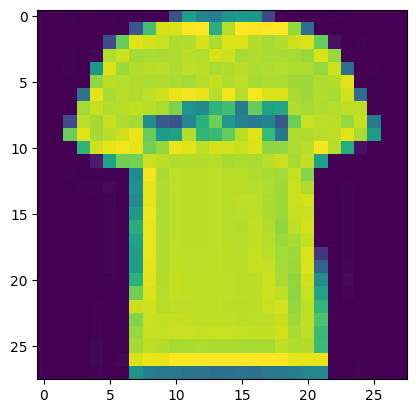

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



# Display the image
plt.imshow(images[2])



In [26]:
image_captions[2]

'A T-shirt with a minimalist design.'

In [27]:
image_classes[2]

0

In [28]:
import numpy as np

# Assuming you have lists images, image_captions, and image_classes containing your data

# Create an array of indices from 0 to the length of your data
indices = np.arange(len(images))

# Randomly select 20,000 indices for testing without replacement
testing_indices = np.random.choice(indices, size=2000, replace=False)

# Use the remaining indices for training
training_indices = np.setdiff1d(indices, testing_indices)

# Use the selected indices to create the testing and training datasets
testing_cnn_data_selected = [images[i] for i in testing_indices]
training_cnn_data_selected = [images[i] for i in training_indices]

testing_lstm_data_selected = [image_captions[i] for i in testing_indices]
training_lstm_data_selected = [image_captions[i] for i in training_indices]

# Create labels (y) for testing and training datasets
testing_labels = [image_classes[i] for i in testing_indices]
training_labels = [image_classes[i] for i in training_indices]


# Now testing_data_selected contains 20,000 randomly selected items for testing
# and training_data_selected contains the remaining items for training
# testing_labels and training_labels contain corresponding labels for testing and training datasets


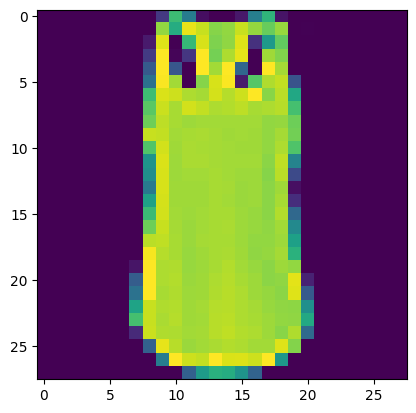

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



# Display the image
plt.imshow(training_cnn_data_selected[1])



In [30]:
import numpy as np

# Sample testing_labels array
training_labels = np.array(training_labels)

# Define a mapping dictionary to map original labels to new labels (0 to 20)
label_mapping = {}
new_label = 0
for label in sorted(np.unique(training_labels)):
    label_mapping[label] = new_label
    new_label += 1

# Convert the testing_labels array using the mapping dictionary
converted_labels_training = np.array([label_mapping[label] for label in training_labels])

# Print the converted labels
print(converted_labels_training)


[0 0 0 ... 9 9 9]


In [31]:
import numpy as np

# Sample testing_labels array
testing_labels = np.array(testing_labels)

# Define a mapping dictionary to map original labels to new labels (0 to 20)
label_mapping = {}
new_label = 0
for label in sorted(np.unique(testing_labels)):
    label_mapping[label] = new_label
    new_label += 1

# Convert the testing_labels array using the mapping dictionary
converted_labels_testing = np.array([label_mapping[label] for label in testing_labels])

# Print the converted labels
print(converted_labels_testing)


[6 7 9 ... 6 5 0]


In [32]:
testing_labels[0:10]

array([6, 7, 9, 0, 8, 3, 3, 2, 3, 3])

In [33]:
converted_labels_testing[0:10]

array([6, 7, 9, 0, 8, 3, 3, 2, 3, 3])

In [34]:
testing_labels.shape

(2000,)

In [35]:
converted_labels_training[450:460]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [36]:
training_lstm_data_selected[1]

'A T-shirt with a cropped hem.'

## CNN 

In [37]:
# Convert labels to one-hot encoding
training_labels=np.array(training_labels)
testing_labels=np.array(testing_labels)
training_labels = tf.keras.utils.to_categorical(converted_labels_training, 10)
testing_labels = tf.keras.utils.to_categorical(converted_labels_testing, 10)

In [38]:
training_cnn_data_selected=np.array(training_cnn_data_selected)

In [39]:
testing_cnn_data_selected=np.array(testing_cnn_data_selected)

In [40]:
training_cnn_data_selected.shape

(2998, 28, 28)

In [46]:
testing_cnn_data_selected.shape

(2000, 28, 28)

In [47]:
training_cnn_data_selected = training_cnn_data_selected.reshape((2998, 28, 28, 1))
testing_cnn_data_selected = testing_cnn_data_selected.reshape((2000, 28, 28, 1))

In [42]:
tf.config.experimental_run_functions_eagerly(False)

In [43]:
training_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [44]:
training_labels.shape

(2998, 10)

training_cnn_data_selected = np.expand_dims(training_cnn_data_selected, axis=-1)
testing_cnn_data_selected = np.expand_dims(testing_cnn_data_selected, axis=-1)

In [50]:
cnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(training_cnn_data_selected,
                            training_labels,
                            batch_size=32,
                            epochs=30,
                            validation_data=(testing_cnn_data_selected,testing_labels),
                            shuffle=True)

Epoch 1/30


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(None, 28, 28, 1)


In [ ]:
testing_labels = np.argmax(testing_labels, axis=1)
training_labels = np.argmax(training_labels, axis=1)

In [ ]:
cnn_predictions = cnn_model.predict(testing_cnn_data_selected)

In [ ]:
predicted_labels = np.argmax(cnn_predictions, axis=1)

# Calculate accuracy
cnn_accuracy = np.mean(predicted_labels == testing_labels)
print("CNN Model Accuracy:", cnn_accuracy)

In [ ]:
df = pd.DataFrame({'caption': training_lstm_data_selected, 'class': training_labels})

In [ ]:
df[20:30]

In [ ]:

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec

def tokenize_text(text_data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text_data)
    return tokenizer

def train_word2vec(text_data, embedding_dim):
    tokenized_text = [text.split() for text in text_data]
    model = Word2Vec(sentences=tokenized_text, vector_size=embedding_dim, window=5, min_count=1, workers=4)
    return model

def convert_text_to_vectors(text_data, word2vec_model, max_length):
    vectors = []
    for text in text_data:
        words = text.split()
        vec = []
        for word in words:
            if word in word2vec_model.wv:
                vec.append(word2vec_model.wv[word])
            else:
                vec.append(np.zeros(word2vec_model.vector_size))  # Zero vector for out-of-vocabulary words
        vectors.append(vec)
    padded_vectors = pad_sequences(vectors, maxlen=max_length, padding='post')
    return padded_vectors

In [ ]:
df['caption'][147]

In [ ]:
max_words=10000
embedding_dim=10

tokenizer = tokenize_text(df['caption'].values)
word2vec_model = train_word2vec(df['caption'].values, embedding_dim)

max_length = max(len(text.split()) for text in df['caption'].values)

#x_vec = convert_text_to_vectors(df['caption'].values, word2vec_model, max_length)
#class_mapping = {f'class_{i}': i for i in range(num_classes)}
#df['class'] = df['class']

#y = df['class'].values

In [ ]:
x_vec_train = convert_text_to_vectors(training_lstm_data_selected, word2vec_model, max_length)

In [ ]:
x_vec_test = convert_text_to_vectors(testing_lstm_data_selected, word2vec_model, max_length)

In [ ]:
training_lstm_data_selected[2]

In [ ]:
training_lstm_data_selected[0:2]

In [ ]:
x_vec_train=np.array(x_vec_train)

In [ ]:
x_vec_test=np.array(x_vec_test)

In [ ]:
training_labels=np.array(training_labels)
testing_labels=np.array(testing_labels)

In [ ]:
lstm_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
x_vec_train.shape

In [ ]:
training_labels.shape

In [ ]:
x_vec_test.shape

In [ ]:
training_labels = tf.keras.utils.to_categorical(converted_labels_training, 20)
testing_labels = tf.keras.utils.to_categorical(converted_labels_testing, 20)

tf.config.experimental_run_functions_eagerly(True)

In [ ]:
history = lstm_model.fit(x_vec_train,
                                training_labels,
                                batch_size=32,
                                epochs=30,
                                validation_data=(x_vec_test,testing_labels),
                                shuffle=True)

In [ ]:
x_vec_test.shape

In [ ]:
lstm_predictions = lstm_model.predict(x_vec_test)

In [ ]:
predicted_labels = np.argmax(lstm_predictions, axis=1)

# Calculate accuracy
lstm_accuracy = np.mean(predicted_labels == testing_labels)
print("LSTM Model Accuracy:", lstm_accuracy)

In [ ]:
predicted_labels

In [ ]:
testing_labels

In [ ]:
len(cnn_predictions)


In [ ]:
len(lstm_predictions)

In [ ]:
lstm_predictions[0]

## LSTM is working and acc is 86.6% (Cifar 10) - VitGpt2 model
## LSTM is working and acc is 93.6% (Cifar 100 - 20 random classes) - Manually generated captions

In [ ]:
cnn_predictions[0]

In [ ]:
cnn_predictions.shape

In [ ]:
lstm_predictions.shape

In [ ]:
testing_labels

In [ ]:
# Step 5: Late Fusion Ensemble
testing_labels = np.argmax(testing_labels, axis=1)

ensemble_predictions = np.argmax(np.sum([cnn_predictions, lstm_predictions], axis=0), axis=1)

# Step 6: Compare Predictions with Original Classes
accuracy = np.mean(ensemble_predictions == testing_labels)
print("Ensemble Model Accuracy:", accuracy)


## AUTOMATE ENSEMBLE

In [ ]:
import os
import tensorflow as tf

# Define the folder path
folder_path = '/kaggle/input/cnn-models/cnn'

# Get a list of all files in the folder
file_list = os.listdir(folder_path)

# Filter out only the .h5 files
model_files = [file for file in file_list if file.endswith('.h5')]

# Load each model
cnn_models = []
for model_file in model_files[0:4]:
    model_path = os.path.join(folder_path, model_file)
    cnn_model = tf.keras.models.load_model(model_path)
    cnn_models.append(cnn_model)

# Now cnn_models list contains all the loaded CNN models


In [ ]:
# Train each model and track validation accuracy
validation_accuracies = []
for lstm_model in top_lstm_models:
    history = lstm_model.fit(x_vec_train,
                             training_labels,
                             batch_size=32,
                             epochs=1,
                             validation_data=(x_vec_test, testing_labels),
                             shuffle=True)
    
    # Get the validation accuracy from the history
    validation_accuracy = history.history['val_accuracy'][-1]
    validation_accuracies.append(validation_accuracy)

# Sort the models based on validation accuracy
sorted_indices = sorted(range(len(validation_accuracies)), key=lambda i: validation_accuracies[i], reverse=True)
top_lstm_models = [lstm_models[i] for i in sorted_indices[:4]]  # Select the top 4 models

# Train the top 4 LSTM models
histories = []
for lstm_model in top_lstm_models:
    lstm_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = lstm_model.fit(x_vec_train,
                             training_labels,
                             batch_size=32,
                             epochs=1,
                             validation_data=(x_vec_test, testing_labels),
                             shuffle=True)
    histories.append(history)


# Load the LSTM and CNN models
lstm_model = tf.keras.models.load_model('/kaggle/input/lstm-parent-model-final/parent_0_model (1).h5')
cnn_model = tf.keras.models.load_model('/kaggle/input/cnn-model-16layers/cnn_model_.h5')

In [ ]:
from collections import Counter
# Assuming you have lists of predictions from the top LSTM and CNN models
cnn_predictions = [model.predict(testing_cnn_data_selected) for model in cnn_models]
lstm_predictions = [model.predict(x_vec_test) for model in top_lstm_models]

# Combine predictions using majority voting



In [ ]:
from sklearn.metrics import accuracy_score

# Combine predictions using majority voting
def majority_voting(predictions):
    combined_predictions = []
    for sample_predictions in zip(*predictions):
        sample_predictions_list = [tuple(prediction) for prediction in sample_predictions]
        votes = Counter(sample_predictions_list)
        majority_vote = votes.most_common(1)[0][0]
        combined_predictions.append(majority_vote)
    return combined_predictions




# Combine LSTM and CNN predictions using majority voting
ensemble_predictions = majority_voting(lstm_predictions + cnn_predictions)
ensemble_classes = [prediction.index(max(prediction)) for prediction in ensemble_predictions]


predicted_labels = np.argmax(lstm_predictions, axis=1)

# Calculate accuracy
#lstm_accuracy = np.mean(ensemble_predictions == testing_labels)
#print("Ensemble Accuracy:", lstm_accuracy)


# Evaluate ensemble performance
ensemble_accuracy = accuracy_score(testing_labels, ensemble_classes)

In [ ]:
np.shape(lstm_predictions)


In [ ]:
np.shape(cnn_predictions)

In [ ]:
lstm_predictions

In [ ]:
import numpy as np

# Convert lists to NumPy arrays
lstm_predictions_array = np.array(lstm_predictions)
cnn_predictions_array = np.array(cnn_predictions)

# Reshape LSTM and CNN predictions to (num_samples, sequence_length * num_classes)
lstm_predictions_reshaped = lstm_predictions_array.reshape(lstm_predictions_array.shape[0], -1)
cnn_predictions_reshaped = cnn_predictions_array.reshape(cnn_predictions_array.shape[0], -1)

# Concatenate reshaped predictions
x_train = np.concatenate((lstm_predictions_reshaped, cnn_predictions_reshaped), axis=1)

# Assuming y_train contains ground truth labels with shape (num_samples,)


In [ ]:
lstm_predictions[0][0]

In [ ]:
lstm_pred = 

In [ ]:
import numpy as np
import tensorflow as tf

# Prepare Data
# Assuming lstm_predictions, cnn_predictions, and correct_outputs contain the predictions and correct outputs
# Concatenate LSTM and CNN predictions
x_train = np.concatenate((lstm_predictions[0], cnn_predictions[0]), axis=1)

# Calculate Weightage Distribution
# For example, calculate the weightage based on accuracy
lstm_accuracy = accuracy_score(lstm_predictions[0], testing_labels)
cnn_accuracy = accuracy_score(cnn_predictions[0], testing_labels)
total_accuracy = lstm_accuracy + cnn_accuracy
lstm_weight = lstm_accuracy / total_accuracy
cnn_weight = cnn_accuracy / total_accuracy

# Prepare Target Weightage Distribution
target_weightage = np.concatenate((lstm_weight, cnn_weight), axis=1)

# Define Fusion Network Architecture
fusion_network = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_modalities, activation='softmax')  # Output layer for weightage distribution
])

# Compile Fusion Network
fusion_network.compile(optimizer='adam', loss='categorical_crossentropy')

# Train Fusion Network
fusion_network.fit(x_train, target_weightage, epochs=10, batch_size=32, validation_split=0.2)


In [ ]:
ensemble_classes = [prediction.index(max(prediction)) for prediction in ensemble_predictions]


In [ ]:
ensemble_classes[0]

In [ ]:
# CIFAR-10 class names
cifar_10_classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# Printing class names for the first 10 elements in image_classes
print("Class Names:")
for class_index in image_classes[:10]:
    print(cifar_10_classes[class_index])


In [ ]:
image_captions[0:10]

In [ ]:
image_classes[0:10]


In [ ]:

# Define the ensemble function
def ensemble(lstm_outputs, cnn_outputs):
    # Add your ensemble code here
    return lstm_outputs, cnn_outputs

# Make predictions on the image and text data
lstm_predictions = []
cnn_predictions = []
for image_batch, text_batch in zip(image_generator, text_generator):
    lstm_outputs = lstm_model.predict(text_batch)
    cnn_outputs = cnn_model.predict(image_batch)
    lstm_predictions.append(lstm_outputs)
    cnn_predictions.append(cnn_outputs)
lstm_predictions = np.vstack(lstm_predictions)
cnn_predictions = np.vstack(cnn_predictions)

# Ensemble the predictions using voting strategy
ensemble_predictions = ensemble(lstm_predictions, cnn_predictions)

# Take the average of the probabilities from both models for each class
ensemble_predictions = (ensemble_predictions[0] + ensemble_predictions[1]) / 2

# Select the class with the highest average probability as the final prediction
final_predictions = np.argmax(ensemble_predictions, axis=1)